<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/modern_compvis_pytorch_book/road_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zipGTSRB_Final_Test_Images.zip
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 122.2 MB/s eta 

In [3]:
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

In [4]:
import torchvision.transforms as T

train_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8, 1.2),
                  contrast=(0.8, 1.2),
                  saturation=(0.8, 1.2),
                  hue=0.25),
    T.RandomAffine(5, translate=(0.01, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class GTSRB(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

all_files = Glob('/content/GTSRB/Final_Training/Images/*/*.ppm')
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
train_files, valid_files = train_test_split(all_files)

train_ds = GTSRB(train_files, transform=train_tfms)
valid_ds = GTSRB(valid_files, transform=valid_tfms)
train_dl = DataLoader(train_ds, 32, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, 32, shuffle=False, collate_fn=valid_ds.collate_fn)

[11/04/23 09:47:01] INFO     29406                                                                                                 ]8;id=386773;file://<ipython-input-5-3ee9b641cea4>:5\<ipython-input-5-3ee9b641cea4>]8;;\:]8;id=510738;file://<ipython-input-5-3ee9b641cea4>:5#__init__:5\__init__:5]8;;\

                    INFO     9803                                                                                                  ]8;id=360934;file://<ipython-input-5-3ee9b641cea4>:5\<ipython-input-5-3ee9b641cea4>]8;;\:]8;id=430754;file://<ipython-input-5-3ee9b641cea4>:5#__init__:5\__init__:5]8;;\

In [7]:
train_ds[0][0].shape, train_ds[0][1]

((39, 36, 3), 'Priority road')

(-0.5, 35.5, 38.5, -0.5)

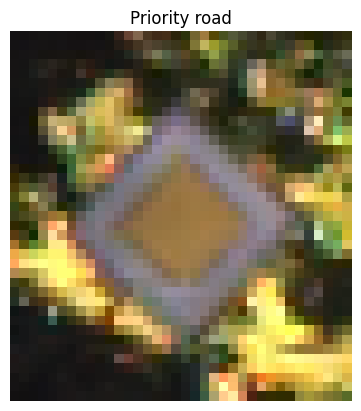

In [8]:
plt.imshow(train_ds[0][0])
plt.title(train_ds[0][1])
plt.axis('off')

In [9]:
len(train_ds)

29406

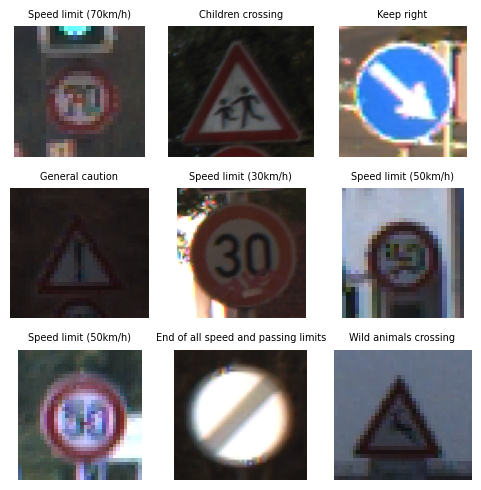

In [10]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(5, 5))

for i in range(nrows):
    for j in range(ncols):
        ix = np.random.randint(0, len(train_ds))
        im = train_ds[ix][0]

        axes[i, j].imshow(im)
        axes[i, j].set_title(train_ds[ix][1], fontsize=7)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
def conv_block(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
    )

In [12]:
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64),
            conv_block(64, 128),
            conv_block(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1]==targets).float().mean()
        return ce_loss, acc

In [13]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

EPOCH: 1.000  val_acc: 0.579  trn_acc: 0.234  val_loss: 1.324  trn_loss: 2.718  (46.83s - 2294.74s remaining)
EPOCH: 2.000  val_acc: 0.712  trn_acc: 0.564  val_loss: 0.893  trn_loss: 1.383  (96.68s - 2320.31s remaining)
EPOCH: 3.000  val_acc: 0.822  trn_acc: 0.676  val_loss: 0.634  trn_loss: 1.033  (144.70s - 2267.04s remaining)
EPOCH: 4.000  val_acc: 0.840  trn_acc: 0.724  val_loss: 0.574  trn_loss: 0.860  (192.49s - 2213.61s remaining)
EPOCH: 5.000  val_acc: 0.829  trn_acc: 0.756  val_loss: 0.594  trn_loss: 0.758  (240.69s - 2166.21s remaining)
EPOCH: 6.000  val_acc: 0.879  trn_acc: 0.782  val_loss: 0.431  trn_loss: 0.684  (288.15s - 2113.10s remaining)
EPOCH: 7.000  val_acc: 0.848  trn_acc: 0.791  val_loss: 0.485  trn_loss: 0.649  (336.10s - 2064.63s remaining)
EPOCH: 8.000  val_acc: 0.845  trn_acc: 0.804  val_loss: 0.500  trn_loss: 0.611  (382.93s - 2010.39s remaining)
EPOCH: 9.000  val_acc: 0.829  trn_acc: 0.815  val_loss: 0.578  trn_loss: 0.576  (431.76s - 1966.91s remaining)
EPO

100%|██████████| 151/151 [00:03<00:00, 45.26it/s]


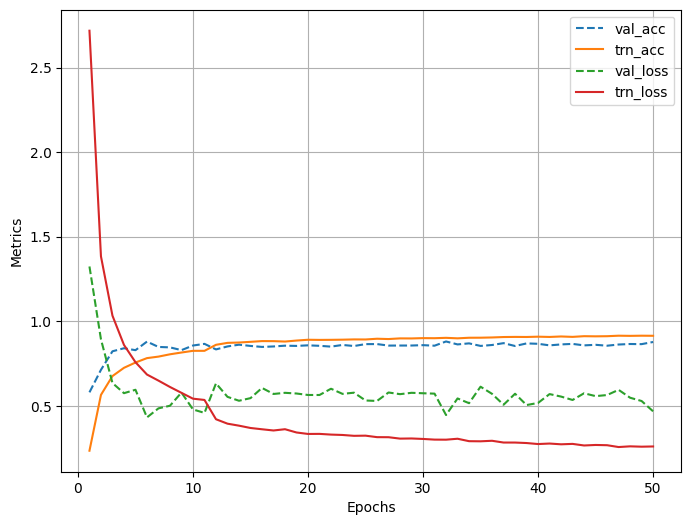

[11/04/23 10:36:19] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 2.24e+00 seconds                         ]8;id=976458;file://<ipython-input-16-6cd49bc070eb>:22\<ipython-input-16-6cd49bc070eb>]8;;\:<cell line: 22>:22

» no-aug-no-bn.log

In [16]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(valid_dl)
    for bx, data in enumerate(valid_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex + (bx + 1) / N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex + 1)
    if ex==10:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')